In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from plot_utils import update_plotstyle, cmap_OB
cmap_OB=cmap_OB(); update_plotstyle()

In [2]:
exp_prefix = ['EXP00','EXP01'] # Import all files with this prefix
exp_suffix = ['_1d10','_1d10']
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'],timestep_slice=(0,360))
if type(ds) != dict: ds={exp_prefix+exp_suffix:ds}

In [3]:
# get base configuration of EXP00
kwargs={}
#kwargs[exp_prefix+exp_suffix] = config_parser(exp_prefix)
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml


In [4]:
phi = ds['EXP00_1d10'].gphit[:,0]
lam = ds['EXP00_1d10'].glamt[0,:]
depth = properties['EXP00_1d10'].coords['Z']
YZ,ZY = np.meshgrid(phi.values,depth.values[:-1])
XY,YX = np.meshgrid(lam.values,phi.values)

/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


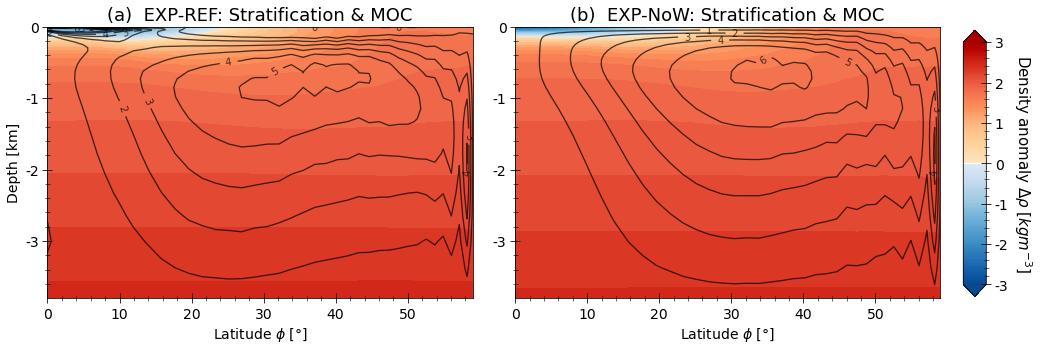

In [5]:
gs_kw = dict(width_ratios=[1,3.5])
fig, ax = plt.subplots(1,2,figsize=(16,5) )#,constrained_layout=True)#, gridspec_kw=gs_kw)

for i, exp in enumerate(ds):
    dn = grid_ops[exp].average(ds[exp].rho-1026,'X').mean('t')#.values-1000
    vmin = -3
    vmax = 3
    qcs=ax[i].contourf(YZ, ZY, dn[:-1], cmap=cmap_OB,extend='both', levels=np.linspace(-3,3,41))
    

    vmin=-6
    vmax=6
    c = ax[i].contour(YZ, ZY, ds[exp].psi.mean('t')[:-1], colors='k',levels=np.linspace(0,6,7),linewidths=1.3,alpha=.7)
    ax[i].clabel(c)
    #ax[i].set_title('(b) Meridional overturning circulation',fontsize=18)
    ax[i].set_xlabel('Latitude $\phi$ [°]',fontsize=14)
    ax[i].set_yticks([-4000,-3000,-2000,-1000,0])
    ax[i].set_yticklabels([0,-1,-2,-3,-4][::-1])
    ax[i].set_ylim(-3800,0)
    ax[i].set_xlim(0,59) 

    prefix = ['(a)  ','(b)  '] 
    prefix1 = ['EXP-REF: ','EXP-NoW: '] 
    suffix = ['Stratification & MOC', 'Stratification & MOC']
    ax[i].set_title(prefix[i]+prefix1[i]+suffix[i],fontsize=18)
ax[0].set_ylabel('Depth [km]',fontsize=14)
ax_cb=fig.add_axes([0.92, 0.13, 0.02, 0.74])
cbar=plt.colorbar(ScalarMappable(norm=qcs.norm, cmap=qcs.cmap),ax=ax_cb,cax=ax_cb,
             ticks=np.arange(vmin, vmax+1, 1),
             extend='both', pad=0.02)

cbar.set_ticklabels(cbar.get_ticks())
#cbar.set_label('$\Psi_{moc}$ [Sv]',rotation=-90,labelpad=25,fontsize=15)
cbar.set_label(r'Density anomaly $\Delta \rho$ [$kg m^{-3}$]',rotation=-90,labelpad=25,fontsize=15)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/Fig3_Mean_final.png', dpi=150, transparent=True, bbox_inches='tight')